## 2D rotation (O is the center of images)

In [1]:
from pathlib import Path
from random import choice, sample
import numpy as np
from matplotlib import pyplot as plt
from skimage import io


In [7]:
ps = list(Path('align_2.0/face').expanduser().glob('*.png'))
len(ps)

27753

align_2.0/face/id_00003707_01_2_side.png


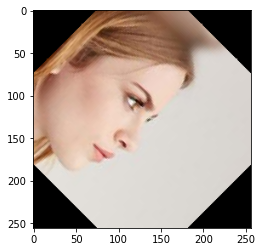

In [12]:
sample_path = choice(ps)
print(sample_path)
image = io.imread(sample_path)

img_transformed = np.zeros((image.shape), dtype=np.uint8)

c, s = np.cos(np.radians(45)), np.sin(np.radians(45))
rot_matrix = np.array([[c, s, 0], [-s, c, 0], [0, 0, 1]])

x, y, _ = np.array(image.shape) // 2
# move center to (0, 0)
translate1 = np.array([[1, 0, -x], [0, 1, -y], [0, 0, 1]])
# move center back to (x, y)
translate2 = np.array([[1, 0, x], [0, 1, y], [0, 0, 1]])

# compose all three transformations together
trans_matrix = translate2 @ rot_matrix @ translate1

for i, row in enumerate(image):
    for j,col in enumerate(row):
        pixel_data = image[i,j] #get the value of pixel at corresponding location
        input_coord = np.array([i, j, 1]) #this will be my [x,y] matrix
        result = trans_matrix @ input_coord 
        i_out, j_out, _ = result #store the resulting coordinate location

        #make sure the the i and j values remain within the index range
        if (0 < int(i_out) < image.shape[0]) and (0 < int(j_out) < image.shape[1]):
            img_transformed[int(i_out)][int(j_out)] = pixel_data
            
# lookup original pixel value to deal with [aliasing](https://en.wikipedia.org/wiki/Aliasing)
inverse_tform = np.linalg.inv(trans_matrix)

for i, j in np.ndindex(img_transformed.shape[:2]):
    i_orig, j_orig, _ = np.round(inverse_tform @ [i, j, 1]).astype(int)
    if i_orig in range(image.shape[0]) and j_orig in range(image.shape[1]):
        img_transformed[i, j] = image[i_orig, j_orig]
            
plt.imshow(img_transformed)

In [ ]:
import cv2
import numpy as np


def transform(image,
              translation=(0, 0, 0),
              rotation=(0, 0, 0),
              scaling=(1, 1, 1),
              shearing=(0, 0, 0)):
    
    # get the values on each axis
    t_x, t_y, t_z = translation
    r_x, r_y, r_z = rotation
    sc_x, sc_y, sc_z = scaling
    sh_x, sh_y, sh_z = shearing
    
    # convert degree angles to rad
    theta_rx = np.deg2rad(r_x)
    theta_ry = np.deg2rad(r_y)
    theta_rz = np.deg2rad(r_z)
    theta_shx = np.deg2rad(sh_x)
    theta_shy = np.deg2rad(sh_y)
    theta_shz = np.deg2rad(sh_z)
    
    # get the height and the width of the image
    h, w = image.shape[:2]
    # compute its diagonal
    diag = (h ** 2 + w ** 2) ** 0.5
    # compute the focal length
    f = diag
    if np.sin(theta_rz) != 0:
        f /= 2 * np.sin(theta_rz)
        
    # set the image from cartesian to projective dimension
    H_M = np.array([[1, 0, -w / 2],
                    [0, 1, -h / 2],
                    [0, 0,      1],
                    [0, 0,      1]])
    # set the image projective to carrtesian dimension
    Hp_M = np.array([[f, 0, w / 2, 0],
                     [0, f, h / 2, 0],
                     [0, 0,     1, 0]])
    
    # adjust the translation on z
    t_z = (f - t_z) / sc_z ** 2
    # translation matrix to translate the image
    T_M = np.array([[1, 0, 0, t_x],
                    [0, 1, 0, t_y],
                    [0, 0, 1, t_z],
                    [0, 0, 0,  1]])
    
    # calculate cos and sin of angles
    sin_rx, cos_rx = np.sin(theta_rx), np.cos(theta_rx)
    sin_ry, cos_ry = np.sin(theta_ry), np.cos(theta_ry)
    sin_rz, cos_rz = np.sin(theta_rz), np.cos(theta_rz)
    # get the rotation matrix on x axis
    R_Mx = np.array([[1,      0,       0, 0],
                     [0, cos_rx, -sin_rx, 0],
                     [0, sin_rx,  cos_rx, 0],
                     [0,      0,       0, 1]])
    # get the rotation matrix on y axis
    R_My = np.array([[cos_ry, 0, -sin_ry, 0],
                     [     0, 1,       0, 0],
                     [sin_ry, 0,  cos_ry, 0],
                     [     0, 0,       0, 1]])
    # get the rotation matrix on z axis
    R_Mz = np.array([[cos_rz, -sin_rz, 0, 0],
                     [sin_rz,  cos_rz, 0, 0],
                     [     0,       0, 1, 0],
                     [     0,       0, 0, 1]])
    # compute the full rotation matrix
    R_M = np.dot(np.dot(R_Mx, R_My), R_Mz)
   
    
    # get the scaling matrix
    Sc_M = np.array([[sc_x,     0,    0, 0],
                     [   0,  sc_y,    0, 0],
                     [   0,     0, sc_z, 0],
                     [   0,     0,    0, 1]])


    Identity = np.array([[1, 0, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])
    
    # get the tan of angles
    tan_shx = np.tan(theta_shx)
    tan_shy = np.tan(theta_shy)
    tan_shz = np.tan(theta_shz)
    # get the shearing matrix on x axis
    Sh_Mx = np.array([[      1, 0, 0, 0],
                      [tan_shy, 1, 0, 0],
                      [tan_shz, 0, 1, 0],
                      [      0, 0, 0, 1]])
    # get the shearing matrix on y axis
    Sh_My = np.array([[1, tan_shx, 0, 0],
                      [0,       1, 0, 0],
                      [0, tan_shz, 1, 0],
                      [0,       0, 0, 1]])
    # get the shearing matrix on z axis
    Sh_Mz = np.array([[1, 0, tan_shx, 0],
                      [0, 1, tan_shy, 0],
                      [0, 0,       1, 0],
                      [0, 0,       0, 1]])
    # compute the full shearing matrix
    Sh_M = np.dot(np.dot(Sh_Mx, Sh_My), Sh_Mz)
    
    
    # compute the full transform matrix
    M = Identity
    M = np.dot(T_M,  M)
    M = np.dot(R_M,  M)
    M = np.dot(Sc_M, M)
    M = np.dot(Sh_M, M)
    M = np.dot(Hp_M, np.dot(M, H_M))
    # apply the transformation
    image = cv2.warpPerspective(image, M, (w, h))
    return image

class Slider:
    def __init__(self, name, shape, min_val, max_val, start=None):
        self.name = name
        self.shape = shape
        self.min_val = min_val
        self.max_val = max_val
        self.value = start
        # set the cursor to the middle of the slider by default
        if self.value is None:
            self.value = (self.min_val + self.max_val) / 2
            
    def set_cursor(self, x):
        # normalize the x-coordinate according to the img shape
        x =  x / self.shape[1]
        # rescale it according to its minimum / maximum value
        x_rescale = x * (self.max_val - self.min_val) + self.min_val
        # check it does not go outside the slider
        if self.min_val < x_rescale <= self.max_val:
            self.value = x_rescale
            
    def get_image(self):
        # set the background to black
        slider_img = np.ones((*self.shape, 3))
        # draw the slider as a centered rectangle in the image
        pt1 = ( 1 * self.shape[1] // 20,  10 * self.shape[0] // 20)
        pt2 = (19 * self.shape[1] // 20,  11 * self.shape[0] // 20)
        cv2.rectangle(slider_img, pt1, pt2, (0.6, 0.6, 0.6) , 5)
        cv2.rectangle(slider_img, pt1, pt2, (0.8, 0.8, 0.8),-1)
        # put the name and the current state value
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = f'{self.name} : {self.value:.1f}'
        cv2.putText(slider_img, text, (0, 25), font, .8, 0, 2)
        # get the slider's value and rescale it to set the cursor
        # at its right place according to the slider on the image
        x = (self.value -self.min_val) /(self.max_val -self.min_val)
        x = self.shape[1] // 20 + 18 * self.shape[1] // 20 * x
        x = int(x)
        # draw the cursor as a rectangle too
        pt1 = (x - self.shape[1] // 100, 2 * self.shape[0] // 10)
        pt2 = (x + self.shape[1] // 100, 8 * self.shape[0] // 10)
        cv2.rectangle(slider_img, pt1, pt2, (0.6, 0.6, 0.6) , 5)
        cv2.rectangle(slider_img, pt1, pt2, (0.8, 0.8, 0.8), -1)
        return slider_img

class SliderStacker():
    def __init__(self, sliders):
        # get the sliders and their height assuming
        # they all have the same shape
        self.sliders = sliders
        self.slider_height = self.sliders[0].shape[0]
        # create an attribute to remember 
        # if the left mouse button is pressed
        self.l_pressed = False
        self.frame = np.zeros((100, 100, 3))
        # Create a window to interact with the sliders
        cv2.namedWindow('Sliders', cv2.WINDOW_NORMAL)
        cv2.setMouseCallback('Sliders', self.mouse_event)
        
    def mouse_event(self, event, x, y, flags, param):
        # get the index of the slider 
        # where the mouse is and its y-coordinates
        index, y = y // self.slider_height,  y % self.slider_height
        # If the left click is pressed, get the slider index
        if event == cv2.EVENT_LBUTTONDOWN:
            self.l_pressed = True
            self.slider_idx = index
            # set the new value according 
            # to the y-coordinate of the mouse
            self.sliders[self.slider_idx].set_cursor(x)
        # If the mouse is moving while dragging a cursor
        # set its new position
        elif event == cv2.EVENT_MOUSEMOVE and self.l_pressed:
            self.sliders[self.slider_idx].set_cursor(x)
        # If the left click is released
        elif event == cv2.EVENT_LBUTTONUP:
            self.l_pressed = False
            
    def update(self):
        # get each slider image
        img_sliders = [s.get_image() for s in self.sliders]
        img_sliders = np.vstack((img_sliders))
        self.frame = img_sliders
        # display stacking them vertically
        cv2.imshow('Sliders', img_sliders)

if __name__ == '__main__':
    img_input = cv2.imread('logo.jpg')
    cv2.namedWindow('Rendering', cv2.WINDOW_NORMAL)
    slider_shape = (1000 // 12, 1000)
    h, w, _ = img_input.shape
    
    sliders = []
    sliders.append(Slider('T(x)', slider_shape, - w, w))
    sliders.append(Slider('T(y)', slider_shape, - h, h))
    sliders.append(Slider('T(z)', slider_shape, - 2 * (h+w), 2 * (h+w)))
    sliders.append(Slider('R(x)', slider_shape, -180, 180))
    sliders.append(Slider('R(y)', slider_shape, -180, 180))
    sliders.append(Slider('R(z)', slider_shape, -180, 180))
    sliders.append(Slider('Sc(x)', slider_shape, -2, 2, start=1))
    sliders.append(Slider('Sc(y)', slider_shape, -2, 2, start=1))
    sliders.append(Slider('Sc(z)', slider_shape, -2, 2, start=1))
    sliders.append(Slider('Sh(x)', slider_shape, -180, 180))
    sliders.append(Slider('Sh(y)', slider_shape, -180, 180))
    sliders.append(Slider('Sh(z)', slider_shape, -180, 180))
    params = SliderStacker(sliders)
    
    while True:
        slider_values = [s.value for s in params.sliders]
        trans = tuple(slider_values[:3])
        rot = tuple(slider_values[3:6])
        scale = tuple(slider_values[6:9])
        shear = tuple(slider_values[9:])
        params.update()
        img_output = transform(img_input, trans, rot, scale, shear)
        cv2.imshow('Rendering', img_output)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()